# Project 3: Graphical Models and VI

## Part 1. Image De-noising Using Markov Random Field

The goal of this first part of this project is to generalize and implement the image de-noising algorithm presented in Section 8.3.3 in [1] to non-binary grayscale images. It is recommended that students use grayscale standard images (e.g., Lena) and adapt to the resolution to a reasonable size (somewhere between 3 and 8 bit depending on available processing power). Noisy versions of the images can then be obtained by adding artificial noise where the students can control the noise parameter (e.g., noise energy). For this setup, derive and implement an image de-noising algorithm that is based on Markov random fields. Evaluate the performance of your algorithm by measuring the mean-squared error (MSE) after de-noising, averaged over sufficiently many noise realizations, and plotting the MSE over the noise parameter. Note that in this part, it is sufficient to adjust / optimize the parameters of the potential functions offline (i.e., they do not need to be estimated as part of the image de-noising algorithm).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import scipy

### Prepare the data:

Grayscale standard images "Lena", resolution 8 bit. Shape 256*256.

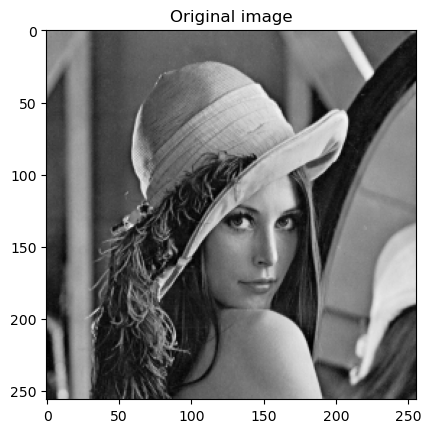

In [35]:
image = plt.imread("./lena.tiff")
plt.imshow(image,cmap=cm.gray)
plt.title('Original image')
plt.show()

In [11]:
print('The shape of the image: ', image.shape, '. The size: ', image.size)

The shape of the image:  (256, 256) . The size:  65536


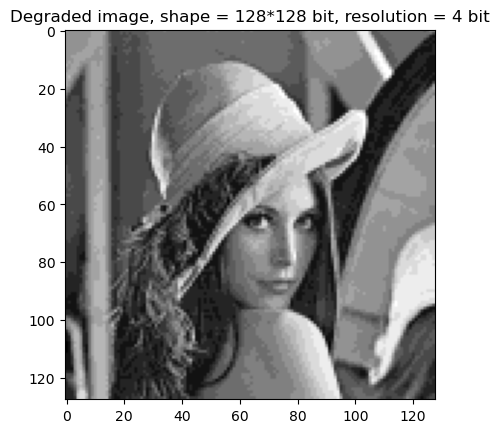

In [288]:
degraded_image = image/16
degraded_image = np.average(degraded_image.reshape((128,2,128,2)), (1,3) )
degraded_image = np.rint(degraded_image)
plt.imshow(degraded_image,cmap=cm.gray)
plt.title('Degraded image, shape = 128*128 bit, resolution = 4 bit')
plt.show()


Adding Gaussian white noise to the image. With controlled noise parameter.

The MSE of the noisy image: 0.32342529296875


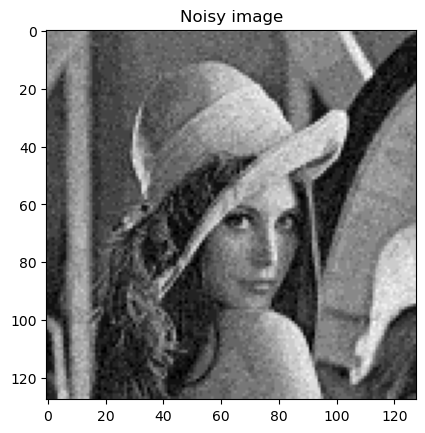

In [375]:
noise_level = 0.5 # Variance of the white noise. 
noisy_image = degraded_image + np.rint(noise_level*np.random.randn(128,128))
noisy_image[noisy_image<0]=0
noisy_image[noisy_image>15]=15

plt.imshow(noisy_image,cmap=cm.gray)
plt.title('Noisy image')
plt.show

print('The MSE of the noisy image:' , ((noisy_image - degraded_image)**2).mean() )

### De-noising algorithm based on Markov random fields:


In [278]:
def ICM(noisy_image):
    h = 0
    beta = 2
    eta = 10
    image=np.copy(noisy_image) # Initialize
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            energies = [] # initialize our energy buffer
            for pixel in range(16): # Depth of the image is known as 4 bit, search for a local lowest energy.
                energy = h * (pixel-8) **2
                if row > 0:
                    energy += beta * (pixel - image[row-1][col])**2
                if row < image.shape[0]-1:
                    energy += beta * (pixel - image[row+1][col])**2
                if col > 0:
                    energy += beta * (pixel - image[row][col-1])**2
                if col < image.shape[1]-1:
                    energy += beta * (pixel - image[row][col+1])**2
                energy += eta * (pixel - noisy_image[row][col]) **2
                energies.append(energy)
            image[row][col] = np.argmin(energies)
    return image

MSE of our denoised image: 0.3095703125


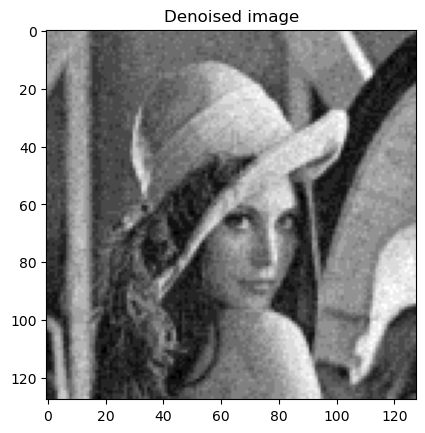

In [376]:
denoised_image = ICM(noisy_image)
plt.imshow(denoised_image,cmap=cm.gray)
plt.title('Denoised image')
plt.show
print('MSE of our denoised image:', ((denoised_image - degraded_image)**2).mean() )

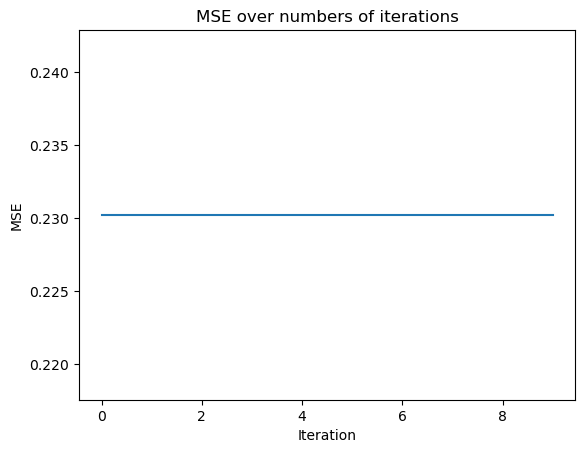

In [425]:
# check the iteration rounds
MSE = []
for i in range(10): # average over 10 times
    noisy_image = ICM(noisy_image)
    MSE.append( ((denoised_image - degraded_image)**2).mean() )

plt.plot(MSE)
plt.xlabel('Iteration') 
plt.ylabel('MSE')
plt.title('MSE over numbers of iterations')
plt.show()

As shown in the graph, it's converging at the beginning. So we only need to call the algorithm once is enough.

### Evaluation

Evaluate the performance of your algorithm by measuring the mean-squared error (MSE) after de-noising, averaged over sufficiently many noise realizations, and plotting the MSE over the noise parameter.

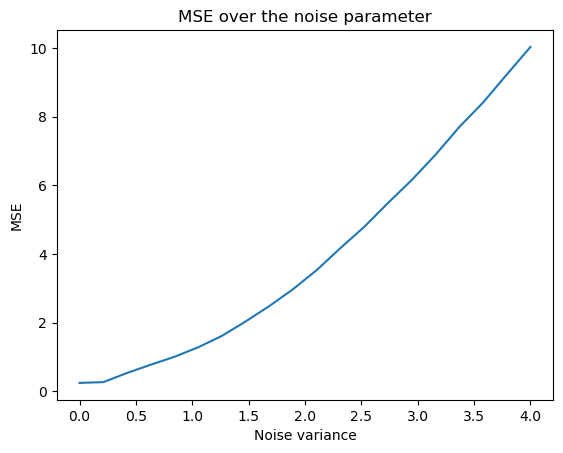

In [358]:
variance_space = np.linspace(0,4,20)
MSE = []
for v in variance_space:
    mse = 0
    for i in range(10): # average over 10 times
        noisy_image = degraded_image + np.rint(v*np.random.randn(128,128))
        noisy_image[noisy_image<0]=0
        noisy_image[noisy_image>15]=15
        denoised_image = ICM(noisy_image)
        mse += ((denoised_image - degraded_image)**2).mean()
    MSE.append( mse/5 )

plt.plot(variance_space, MSE)
plt.xlabel('Noise variance') 
plt.ylabel('MSE')
plt.title('MSE over the noise parameter')
plt.show()

## Part 2. Image De-noising Using the SP/MS Algorithm

I found it hard to develope the algorithm from scatch. So I used an existing module written by Ryan Lester to help compute the Factorized Graph.  Resourse page:https://github.com/rdlester/pyfac

In [410]:
# We simply count the number of times a certain state appear in our original picture to simulate the factor funtion.
# horizontol factor
cov_h = np.zeros((16,16))
for i in range(128):
    for j in range(127):
        left = int(degraded_image[i][j])
        right = int(degraded_image[i][j+1])
        cov_h[left][right] += 1

# vertical factor
cov_v = np.zeros((16,16))
for i in range(127):
    for j in range(128):
        up = int(degraded_image[i][j])
        down = int(degraded_image[i+1][j])
        cov_v[up][down] += 1

# normalize
for i in range(16):
    if cov_h[i].sum() != 0:
        cov_h[i] = cov_h[i] / cov_h[i].sum()
    else:
        cov_h[i] = 1/16 * np.ones(16)
    if cov_v[i].sum() != 0:
        cov_v[i] = cov_v[i] / cov_v[i].sum()
    else:
        cov_v[i] = 1/16 * np.ones(16)

In [411]:
from graph import Graph

G = Graph()

# add variable nodes
x = []
y = []
rows, cols=128, 128
for i in range(rows):
    col_x = []
    col_y = []
    for j in range(cols):
        col_x.append(G.addVarNode(('x_'+str(i)+'_'+str(j)) , 16))
        col_y.append(G.addVarNode(('y_'+str(i)+'_'+str(j)) , 16))
    x.append(col_x)
    y.append(col_y)

# add factors
# y to x factor
P_y_x = np.eye(16) * 0.68  # 0.68 is when variance=0.5, the probability of the pixel is unchanged.
for i in range(15):
    P_y_x[i][i+1]=0.16
    P_y_x[i+1][i]=0.16
P_y_x[0][1] = 0.32
P_y_x[15][14] = 0.32

for i in range(rows):
    for j in range(cols):
        G.addFacNode(P_y_x, y[i][j], x[i][j])

# x to neighbor factor
# horizontal
for i in range(128):
    for j in range(127):
        G.addFacNode(cov_h, x[i][j], x[i][j+1])

# vertical
for i in range(127):
    for j in range(128):
        G.addFacNode(cov_v, x[i][j], x[i+1][j])

# condition on our observed noisy image
for i in range(rows):
    for j in range(cols):
        pixel = int(noisy_image[i][j])
        y[i][j].condition( pixel )  

# run sum-product and get marginals for variables
marg = G.marginals()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


MSE of our denoised image: 0.230224609375


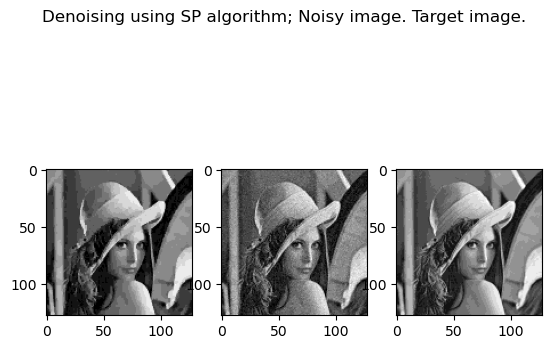

In [424]:
denoised_image = np.zeros((128,128))
for i in range(rows):
    for j in range(cols):
        idx = 'x_'+str(i)+'_'+str(j)
        denoised_image[i][j] = np.argmax(marg[idx]) ## Take the maximum likelihood as our guess.

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Denoising using SP algorithm; Noisy image. Target image. ')
ax1.imshow(denoised_image,cmap=cm.gray)
ax2.imshow(noisy_image,cmap=cm.gray)
ax3.imshow(degraded_image,cmap=cm.gray)
print('MSE of our denoised image:', ((denoised_image - degraded_image)**2).mean() )

Some very good result shown! Significantly better than our simple ICM model.

## Part 3. Variational Methods

The goal of the third part of this project is to apply one variational method from Lecture 4 (Chapter 9.4 and 10 in [1]) to the problem studied in Part 1 and 2 of this project. As a suggestion, the distribution of the pixels p(xi,j) can be modeled as a Gaussian mixture. Use a variational approach to estimate the parameters of the distribution. If successful, you can think about the following extensions: